In [10]:
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn import metrics
from matplotlib.offsetbox import AnchoredText
from multiprocessing import Pool

In [11]:
def TNR(H0, t1):
    
    tnr = torch.count_nonzero(H0 < t1)/torch.tensor(H0.size())
    
    return tnr

def FNR(H1, t1):
    
    fnr = torch.count_nonzero(H1 < t1)/torch.tensor(H1.size())
    
    return fnr

In [12]:
def escavator(dist, targets, source, target):
    
    H = []
    
    for i in torch.nonzero(targets == source)[:,0]:
        for j in filter(lambda h: h>i,torch.nonzero(targets == target)[:,0]):
                H.append(dist[i][j].item())
            
    return torch.tensor(H)

In [13]:
def Calcolator(dist, targets, source, target):

    H0 = escavator(dist, targets, source, source)
    H1 = escavator(dist, targets, source, target)

    t1 = torch.linspace(torch.min(H0), torch.max(H0), 500)

    tnr = torch.zeros(t1.size(0))
    fnr = torch.zeros(t1.size(0))

    for i in range(t1.size(0)):

        tnr[i] = TNR(H0, t1[i])
        fnr[i] = FNR(H1, t1[i])

    return [tnr, fnr, t1]

In [14]:
def AUC(a,b):
    return metrics.auc(a, b)

In [29]:
def Plotter(tnr, fnr, t1, tnr_emb, fnr_emb, t1_emb, source, target, dist, dist_emb, targets, save, sim, type):

    label = ['TNR', '1-FNR']
    hist_label = [f'{source}-{source}', f'{source}-{target}']

    fig = plt.figure(figsize = (14, 21), constrained_layout=False)
    fig.suptitle(f'{source}-prong vs {target}-prong', fontsize = 20)
    
    gs = GridSpec(3, 2, figure = fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlabel('Wasserstein distance', fontsize = 15)
    ax1.set_ylim([-0.1,1.1])

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_xlabel('Wasserstein distance', fontsize = 15)
    ax2.set_ylabel('Density', fontsize = 15)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_xlabel('Euclidean distance', fontsize = 15)
    ax3.set_ylim([-0.1,1.1])

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_xlabel('Euclidean distance', fontsize = 15)
    ax4.set_ylabel('Density', fontsize = 15)

    ax5 = fig.add_subplot(gs[2, 0])
    ax5.set_xlabel('TNR', fontsize = 15)
    ax5.set_ylabel('1-FNR', fontsize = 15)
    ax5.set_ylim([-0.1,1.1])

    ax1.scatter(t1, tnr, s = 5, color = 'b',)
    ax1.scatter(t1, 1-fnr, s = 5, color = 'r')
    ax1.legend(label, loc = 'lower right', fontsize = 12, edgecolor = 'black')

    ax2.hist(escavator(dist, targets, source, source), bins = 'auto', density = True, alpha = 0.5)
    ax2.hist(escavator(dist, targets, source, target), bins = 'auto', density = True, alpha = 0.5)
    ax2.legend(hist_label, loc = 'upper right', fontsize = 12, edgecolor = 'black')

    ax5.scatter(tnr, 1-fnr, s = 5, color = 'purple')

    ax3.scatter(t1_emb, tnr_emb, s = 5, color = 'b')
    ax3.scatter(t1_emb, 1-fnr_emb, s = 5, color = 'r')
    ax3.legend(label, loc = 'lower right', fontsize = 12, edgecolor = 'black')

    ax4.hist(escavator(dist_emb, targets, source, source), bins = 'auto', density = True, alpha = 0.5)
    ax4.hist(escavator(dist_emb, targets, source, target), bins = 'auto', density = True, alpha = 0.5)
    ax4.legend(hist_label, loc = 'upper right', fontsize = 12, edgecolor = 'black')


    ax5.scatter(tnr_emb, 1-fnr_emb, s = 5, color = 'green', alpha = 0.3)
    ax5.legend(['W', 'E'], loc = 'lower left', fontsize = 12, edgecolor = 'black')


    auc = AUC(tnr, 1-fnr)
    auc_emb = AUC(tnr_emb, 1-fnr_emb)
    
    anchored_text_test = AnchoredText('AUC='+str('%.2f' % auc.item())+'\nAUC emb='+str('%.2f' % auc_emb.item()), loc = 'lower left', bbox_to_anchor = (0,0.15), bbox_transform = ax5.transAxes)
    ax5.add_artist(anchored_text_test)


    if save == True:
        if sim == False:
            if type == 'simple':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Simple/{source}-prongsvs{target}-prongs.pdf', facecolor='w',pad_inches=0.3, transparent=True)
            elif type == 'realistic':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Realistic/{source}-prongsvs{target}-prongs.pdf', facecolor='w',pad_inches=0.3, transparent=True)

        elif sim == True:
            if type == 'simple':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Simple/{source}-prongsvs{target}-prongs_sim.pdf', facecolor='w',pad_inches=0.3, transparent=True)
            elif type == 'realistic':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Realistic/{source}-prongsvs{target}-prongs_sim_4D.pdf', facecolor='w',pad_inches=0.3, transparent=True)


In [28]:
def data_loader(sim, type):

    if sim == False:
        if type == 'simple':
            dist, _ = torch.load('/data/gabrieleb/data/Jets/Wasserstein_dist_test_s=4000', map_location = 'cpu')
            dist_emb, targets = torch.load('/data/gabrieleb/data/Jets/E_dist_emb_transformer_s=4000', map_location = 'cpu')

        elif type == 'realistic':
            dist, _ = torch.load('/data/gabrieleb/data/Jets/Wasserstein_dist_test_real_s=4000', map_location = 'cpu')
            dist_emb, targets = torch.load('/data/gabrieleb/data/Jets/E_dist_real_emb_transformer_s=4000', map_location = 'cpu')

    if sim == True:
        if type == 'simple':
            dist, _ = torch.load('/data/gabrieleb/data/Jets/Wasserstein_dist_test_s=4000', map_location = 'cpu')
            dist_emb, targets = torch.load('/data/gabrieleb/data/Jets/E_dist_emb_transformer_sim_s=4000', map_location = 'cpu')
            
        elif type == 'realistic':
            dist, _ = torch.load('/data/gabrieleb/data/Jets/Wasserstein_dist_test_real_s=4000', map_location = 'cpu')
            dist_emb, targets = torch.load('/data/gabrieleb/data/Jets/E_dist_real_emb_transformer_sim_0.2_s=4000', map_location = 'cpu')

    return [dist, dist_emb, targets]

In [27]:
def appendix_plotter(tnr, fnr, t1, tnr_emb, fnr_emb, t1_emb, source, target, save, sim, type):
    label = ['TNR', '1-FNR']
    hist_label = [f'{source}-{source}', f'{source}-{target}']

    fig = plt.figure(figsize = (21, 7), constrained_layout=False)
    fig.suptitle(f'{source}-prong vs {target}-prong', fontsize = 20)
    
    gs = GridSpec(1, 3, figure = fig)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_xlabel('Wasserstein distance', fontsize = 15)
    ax1.set_ylim([-0.1,1.1])

    ax3 = fig.add_subplot(gs[0, 1])
    ax3.set_xlabel('Euclidean distance', fontsize = 15)
    ax3.set_ylim([-0.1,1.1])

    ax5 = fig.add_subplot(gs[0, 2])
    ax5.set_xlabel('TNR', fontsize = 15)
    ax5.set_ylabel('1-FNR', fontsize = 15)
    ax5.set_ylim([-0.1,1.1])

    ax1.scatter(t1, tnr, s = 5, color = 'b',)
    ax1.scatter(t1, 1-fnr, s = 5, color = 'r')
    ax1.legend(label, loc = 'lower right', fontsize = 12, edgecolor = 'black')

    ax5.scatter(tnr, 1-fnr, s = 5, color = 'purple')

    ax3.scatter(t1_emb, tnr_emb, s = 5, color = 'b')
    ax3.scatter(t1_emb, 1-fnr_emb, s = 5, color = 'r')
    ax3.legend(label, loc = 'lower right', fontsize = 12, edgecolor = 'black')

    ax5.scatter(tnr_emb, 1-fnr_emb, s = 5, color = 'green', alpha = 0.3)
    ax5.legend(['W', 'E'], loc = 'lower left', fontsize = 12, edgecolor = 'black')


    auc = AUC(tnr, 1-fnr)
    auc_emb = AUC(tnr_emb, 1-fnr_emb)
    
    anchored_text_test = AnchoredText('AUC='+str('%.2f' % auc.item())+'\nAUC emb='+str('%.2f' % auc_emb.item()), loc = 'lower left', bbox_to_anchor = (0,0.15), bbox_transform = ax5.transAxes)
    ax5.add_artist(anchored_text_test)


    if save == True:
        if sim == False:
            if type == 'simple':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Simple/Appendix/{source}-prongsvs{target}-prongs.pdf', facecolor='w',pad_inches=0.3, transparent=True)
            elif type == 'realistic':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Realistic/Appendix/{source}-prongsvs{target}-prongs.pdf', facecolor='w',pad_inches=0.3, transparent=True)

        elif sim == True:
            if type == 'simple':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Simple/Appendix/{source}-prongsvs{target}-prongs_sim.pdf', facecolor='w',pad_inches=0.3, transparent=True)
            elif type == 'realistic':
                fig.savefig(f'/home/gabrieleb/Plot/Anomaly_Detection/Realistic/Appendix/{source}-prongsvs{target}-prongs_sim.pdf', facecolor='w',pad_inches=0.3, transparent=True)


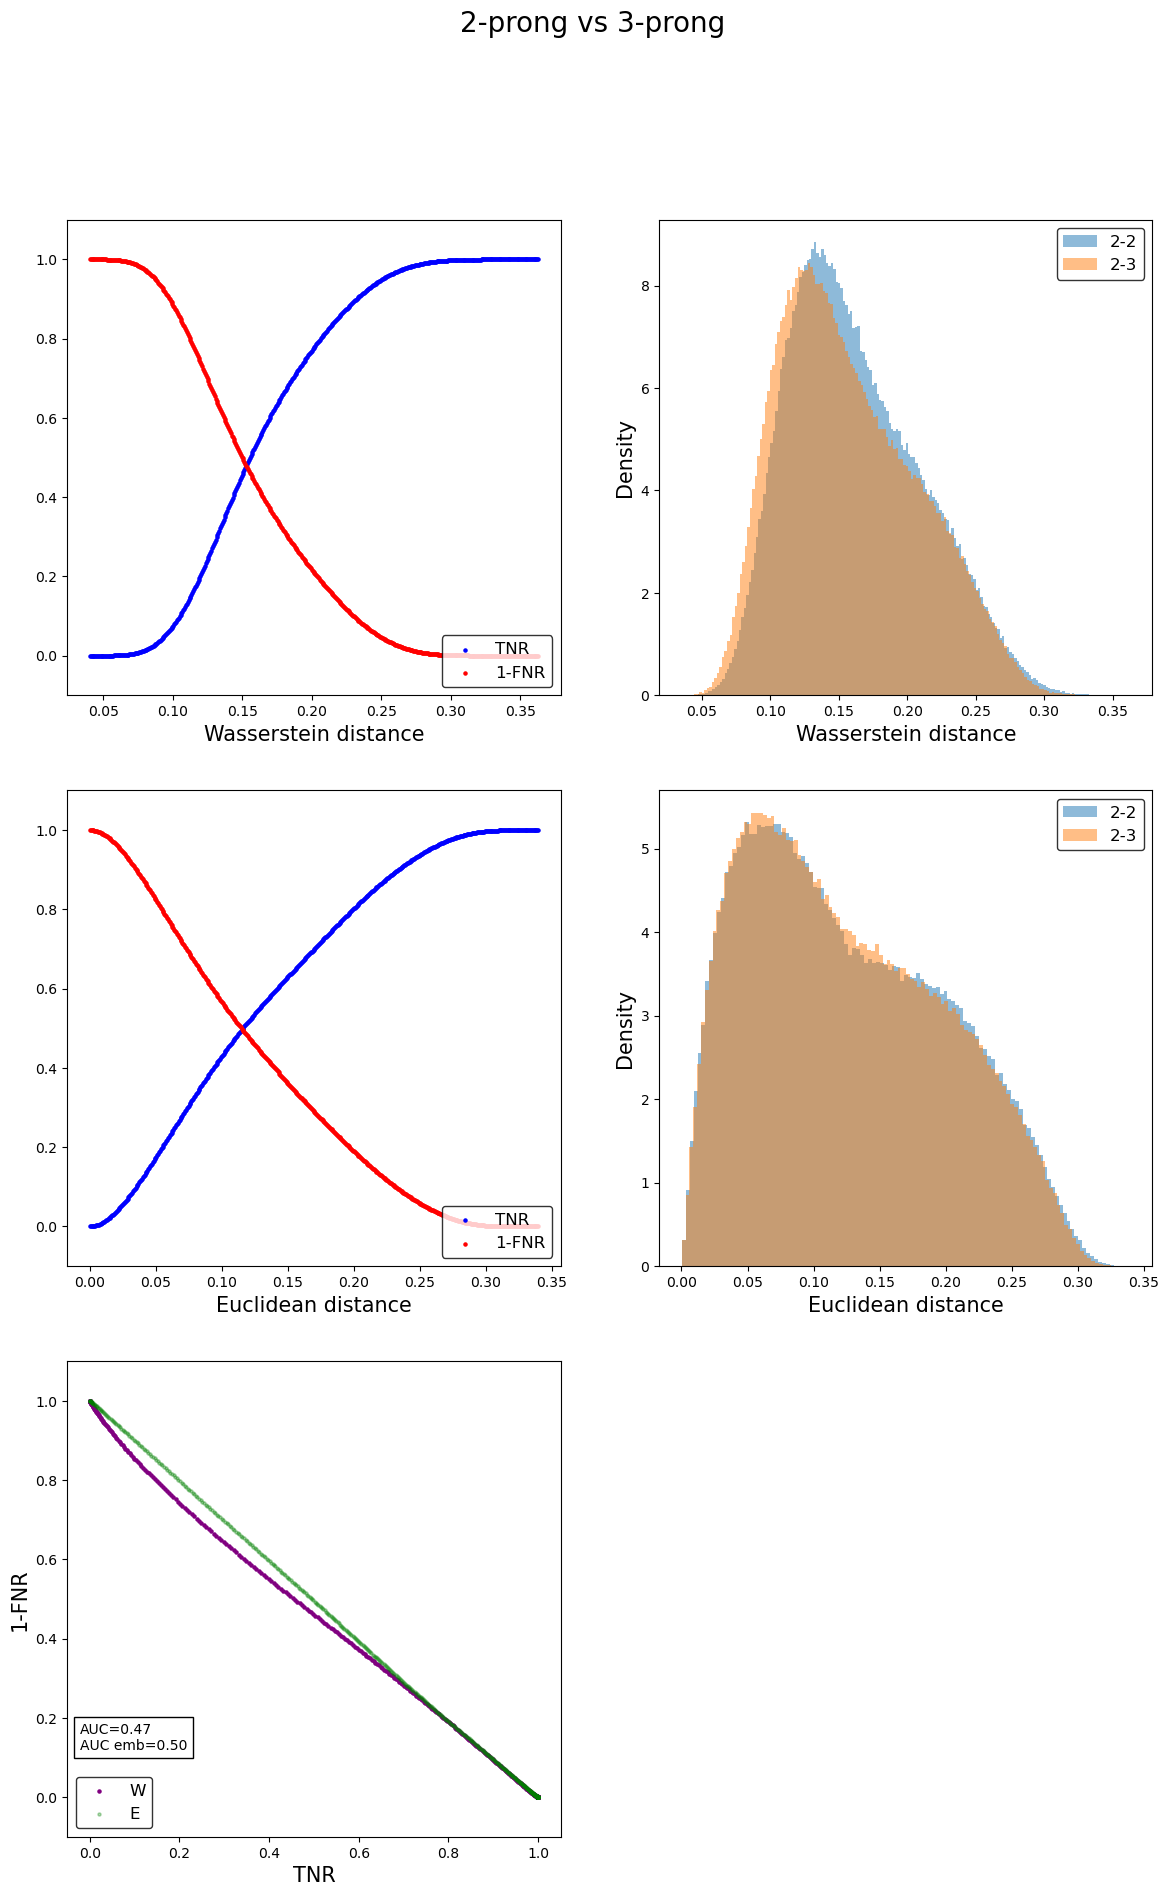

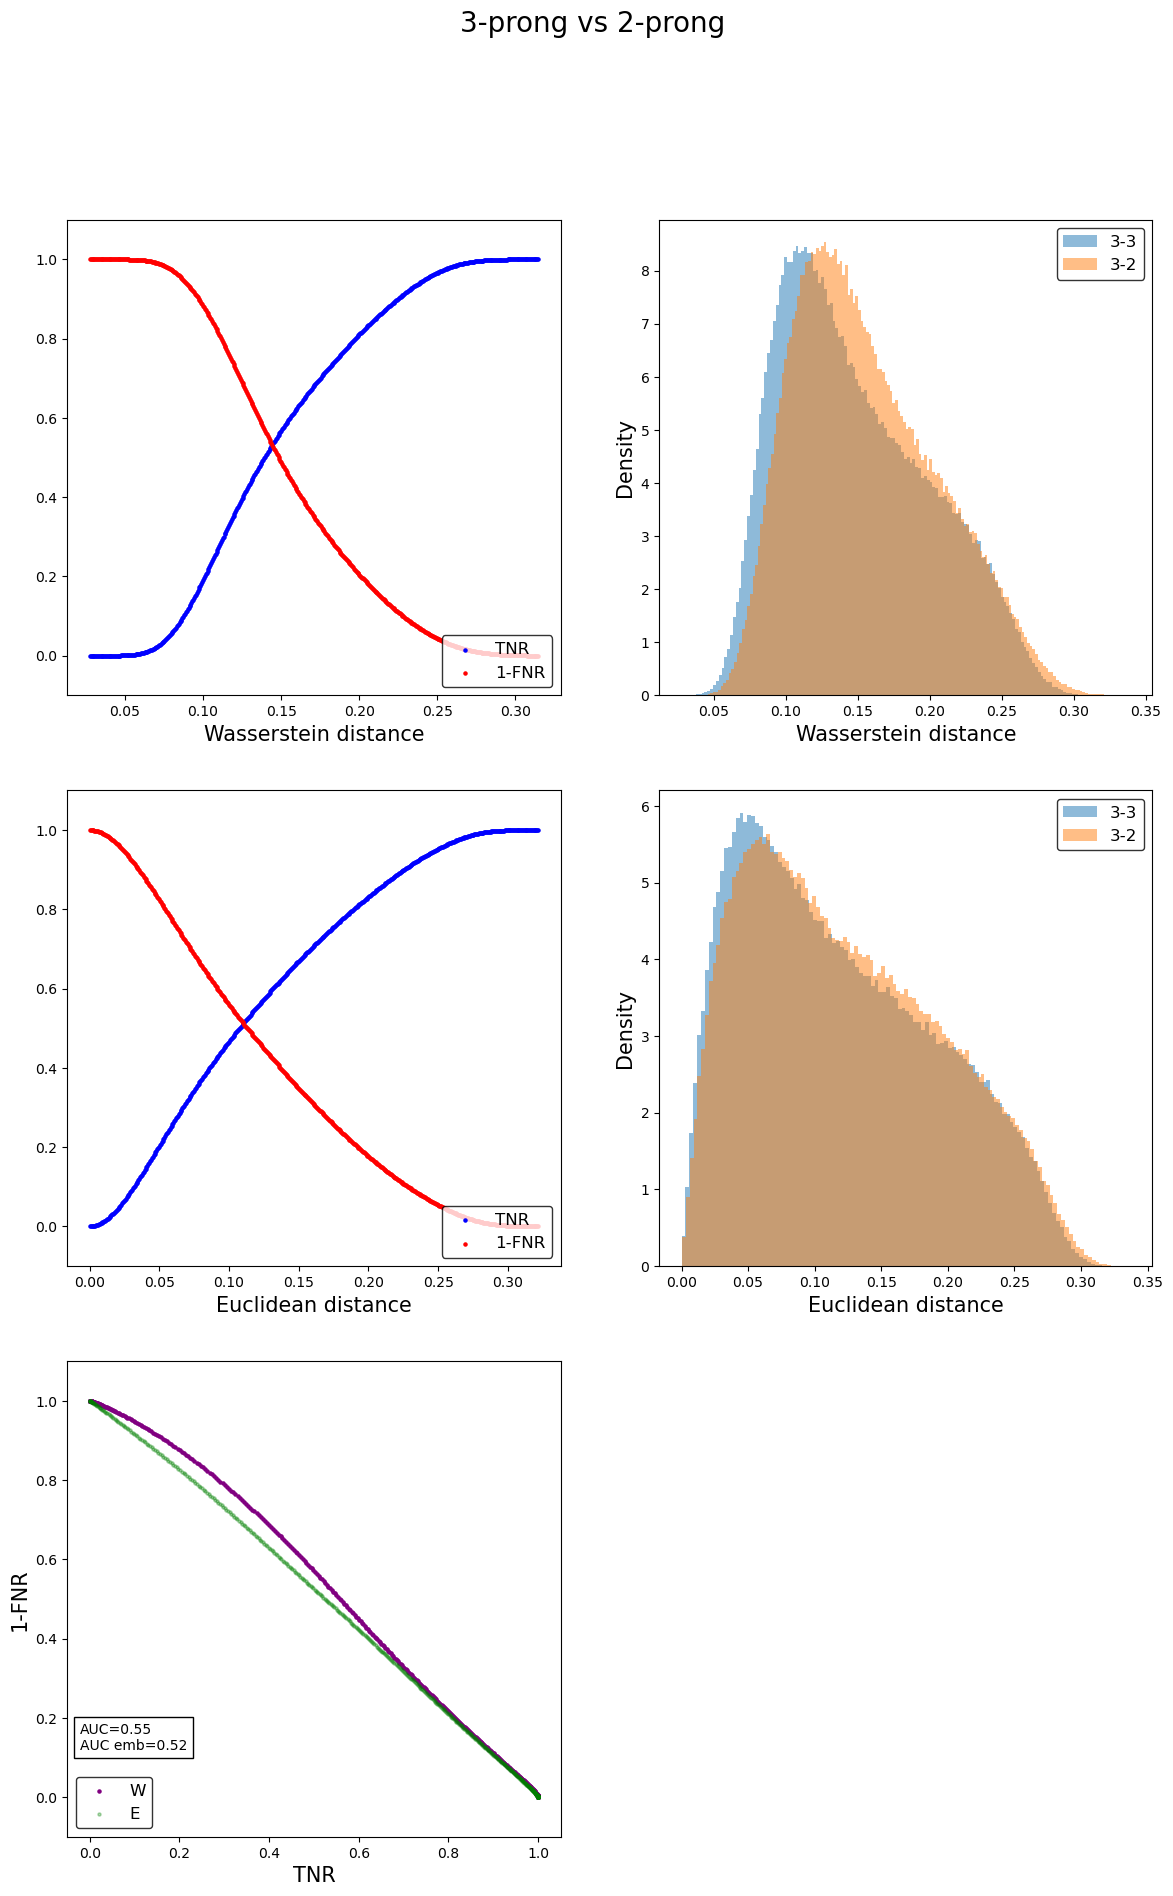

In [32]:
# Console
# - if save == True save the plots,
# - if sim == True the data loss is simetrized,
# - type 'simple' for simple jets, 'realistic' for relistic jets.

save = True
sim = False
type = 'realistic'

dist, dist_emb, targets = data_loader(sim, type)

# prongs = [1, 2, 3, 4]
prongs = [2,3]
for source in prongs:
    for target in filter(lambda h: h != source, prongs):

        tnr, fnr, t1 = Calcolator(dist, targets, source, target)
        tnr_emb, fnr_emb, t1_emb = Calcolator(dist_emb, targets, source, target)

        Plotter(tnr, fnr, t1, tnr_emb, fnr_emb, t1_emb, source, target, dist, dist_emb, targets, save = save, sim = sim, type = type)
        # appendix_plotter(tnr, fnr, t1, tnr_emb, fnr_emb, t1_emb, source, target, save = save, sim = sim, type = type)